>
> # Shared rides with pricing

 ### Changes to:
 * shared.py
 * new function `pool_price.py` (with a debugging logs to see what is happening)
 * used inside `decisions.py\f_match
 * traveller.py (different routine - slightly)
 
 ### Usman choice logic to be applied inside `pool_price.py` 
 (now it is random choice)
 
 ### Tested for Delft, 10 paxes in 10 minutes is enough to debug
 > This notebook was fully working and not thoroughly tested


In [117]:
%load_ext autoreload
%autoreload 2
import os, sys # add MaaSSim to path (not needed if MaaSSim is already in path)
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


prepare

In [118]:
from MaaSSim.utils import get_config, load_G, prep_supply_and_demand, generate_demand, generate_vehicles, initialize_df  # simulator
from MaaSSim.data_structures import structures as inData
from MaaSSim.simulators import simulate
from MaaSSim.visualizations import plot_veh
from MaaSSim.shared import prep_shared_rides
import logging

In [119]:
import pandas as pd

In [120]:
import ExMAS

In [121]:
params = get_config('../../data/config/delft.json')  # load configuration

In [122]:
params.times.pickup_patience = 3600 # 1 hour of simulation
params.simTime = 0.1 # 6 minutes hour of simulation
params.nP = 10 # reuqests (and passengers)
params.nV = 10 # vehicles

In [123]:
params.t0 = pd.Timestamp.now()
params.shareability.avg_speed = params.speeds.ride
params.shareability.shared_discount = 0.3
params.shareability.delay_value = 1
params.shareability.WtS = 1.3
params.shareability.price = 1.5 #eur/km
params.shareability.VoT = 0.0035 #eur/s
params.shareability.matching_obj = 'u_pax' #minimize VHT for vehicles
params.shareability.pax_delay = 0
params.shareability.horizon = 600
params.shareability.max_degree = 4
params.shareability.nP = params.nP
params.shareability.share = 1
params.shareability.without_matching = True

In [124]:
inData = load_G(inData, params)  # load network graph 

In [125]:
inData = generate_demand(inData, params, avg_speed = False)
inData.vehicles = generate_vehicles(inData,params.nV)
inData.vehicles.platform = inData.vehicles.apply(lambda x: 0, axis = 1)
inData.passengers.platforms = inData.passengers.apply(lambda x: [0], axis = 1)
inData.requests['platform'] = inData.requests.apply(lambda row: inData.passengers.loc[row.name].platforms[0], axis = 1) 
inData.platforms = initialize_df(inData.platforms)
inData.platforms.loc[0]=[1,'Uber',30]
params.shareability.share = 1
params.shareability.without_matching = True

In [126]:
inData = ExMAS.main(inData, params.shareability, plot=False) # create shareability graph (ExMAS) 

30-11-22 15:10:36-INFO-Initializing pairwise trip shareability between 10 and 10 trips.
30-11-22 15:10:36-INFO-creating combinations
30-11-22 15:10:36-INFO-90	 nR*(nR-1)
30-11-22 15:10:36-INFO-Reduction of feasible pairs by 96.67%
30-11-22 15:10:36-INFO-Degree 2 	Completed
30-11-22 15:10:36-INFO-trips to extend at degree 2 : 7
30-11-22 15:10:36-INFO-At degree 2 feasible extensions found out of 0 searched
30-11-22 15:10:36-INFO-Degree 3 	Completed
30-11-22 15:10:36-INFO-No more trips to exted at degree 3


In [127]:
inData = prep_shared_rides(inData, params.shareability) # prepare schedules

30-11-22 15:10:36-INFO-Matching 10 trips to 17 rides in order to min u_pax
30-11-22 15:10:36-INFO-Problem solution: Optimal. 
Total costs for single trips:             57 
reduced by matching to:                   54


In [128]:
inData.sblts.rides

,indexes,u_pax,u_veh,kind,u_paxes,times,indexes_orig,indexes_dest,degree,index,PassHourTrav_ns,row,selected,nodes,req_id,sim_schedule,ttrav,dist,fare
0,[0],5.92000,320,1,[5.92],"[0, 320]",[0],[0],1,0,320,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,"[None, 44843109, 1558185438]","[None, 0, 0]",node time req_id od 0 ...,320,3.20,4.800
1,[1],5.61150,303,1,[5.6115],"[23, 303]",[1],[1],1,1,303,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[None, 44856086, 2341955079]","[None, 1, 1]",node time req_id od 0 ...,303,3.03,4.545
2,[2],2.39700,129,1,[2.3970000000000002],"[58, 129]",[2],[2],1,2,129,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,"[None, 1584502762, 1393024905]","[None, 2, 2]",node time req_id od 0 ...,129,1.29,1.935
3,[3],7.92700,428,1,[7.9270000000000005],"[61, 428]",[3],[3],1,3,428,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[None, 5008459643, 44831869]","[None, 3, 3]",node time req_id od 0 ...,428,4.28,6.420
4,[4],5.85350,316,1,[5.8534999999999995],"[66, 316]",[4],[4],1,4,316,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[None, 44792321, 44867166]","[None, 4, 4]",node time req_id od 0 NaN...,316,3.16,4.740
5,[5],3.48700,188,1,[3.487],"[123, 188]",[5],[5],1,5,188,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",0,"[None, 1571087552, 4300758655]","[None, 5, 5]",node time req_id od 0 ...,188,1.88,2.820
6,[6],5.21200,281,1,[5.212000000000001],"[125, 281]",[6],[6],1,6,281,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",1,"[None, 1668136725, 44805508]","[None, 6, 6]",node time req_id od 0 ...,281,2.81,4.215
7,[7],9.02950,488,1,[9.0295],"[214, 488]",[7],[7],1,7,488,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",0,"[None, 44711143, 1699388261]","[None, 7, 7]",node time req_id od 0 ...,488,4.88,7.320
8,[8],3.83100,207,1,[3.831],"[221, 207]",[8],[8],1,8,207,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",1,"[None, 44803328, 4244384215]","[None, 8, 8]",node time req_id od 0 ...,207,2.07,3.105
9,[9],8.05050,435,1,[8.0505],"[299, 435]",[9],[9],1,9,435,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[None, 44864083, 5133225964]","[None, 9, 9]",node time req_id od 0 ...,435,4.35,6.525


simulate

In [129]:
sim = simulate(params = params, inData = inData, logger_level = logging.WARNING) # simulate

30-11-22 15:10:40-INFO-Matching 10 trips to 17 rides in order to min u_pax
30-11-22 15:10:41-INFO-Problem solution: Optimal. 
Total costs for single trips:             57 
reduced by matching to:                   54
30-11-22 15:10:41-WARNING-Setting up 0.1h simulation at 2022-11-30 15:07:50 for 10 vehicles and 10 passengers in Delft, Netherlands
30-11-22 15:10:41-CRITICAL-this is reuqest 1 with [1, 10, 16] available rides.
30-11-22 15:10:41-CRITICAL-ride 1 available [1]
30-11-22 15:10:41-CRITICAL-ride 10 available [1, 0]
30-11-22 15:10:41-CRITICAL-ride 16 available [0, 1]
30-11-22 15:10:41-CRITICAL-this is reuqest 1 with [1, 10, 16] still available rides.
30-11-22 15:10:41-CRITICAL-vehicle 9 has chosen to serve request 1 with a ride 1 of degree 1, with travellers [1].
30-11-22 15:10:41-CRITICAL-this is reuqest 3 with [3, 11, 12, 14] available rides.
30-11-22 15:10:41-CRITICAL-ride 3 available [1]
30-11-22 15:10:41-CRITICAL-ride 11 available [1, 0]
30-11-22 15:10:41-CRITICAL-ride 12 no

In [130]:
sim.inData.requests.position

pax
0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: position, dtype: int64

In [131]:
df = sim.runs[0].rides
df[df.veh==1]

,veh,pos,t,event,paxes
0,1,4.487213e+07,0.0,STARTS_DAY,[]
1,1,4.487213e+07,0.0,OPENS_APP,[]
2,1,4.487213e+07,0.0,RECEIVES_REQUEST,[]
3,1,4.487213e+07,15.0,ACCEPTS_REQUEST,[]
4,1,4.487213e+07,35.0,IS_ACCEPTED_BY_TRAVELLER,[]
5,1,4.484311e+07,158.0,ARRIVES_AT_PICKUP,[]
6,1,4.484311e+07,158.0,MEETS_TRAVELLER_AT_PICKUP,[]
7,1,4.484311e+07,188.0,DEPARTS_FROM_PICKUP,[0]
8,1,1.558185e+09,508.0,ARRIVES_AT_DROPOFF,[0]
9,1,1.558185e+09,7559.0,ENDS_SHIFT,[]


In [132]:
trips = sim.runs[0].trips
trips[trips.pax==8]

,pax,pos,t,event,veh_id
0,8,44803328,0,STARTS_DAY,NaN
1,8,44803328,221,REQUESTS_RIDE,NaN
2,8,44803328,221,RECEIVES_OFFER,NaN
3,8,44803328,236,ACCEPTS_OFFER,NaN
4,8,44803328,256,ARRIVES_AT_PICKUP,2.0
5,8,44803328,501,MEETS_DRIVER_AT_PICKUP,2.0
6,8,44803328,531,DEPARTS_FROM_PICKUP,2.0
7,8,4244384215,738,ARRIVES_AT_DROPOFF,2.0
8,8,4244384215,748,SETS_OFF_FOR_DEST,NaN
9,8,4244384215,748,ARRIVES_AT_DEST,NaN


In [133]:
trips[trips.pax==0]

,pax,pos,t,event,veh_id
0,0,44843109,0,STARTS_DAY,NaN
1,0,44843109,0,REQUESTS_RIDE,NaN
2,0,44843109,0,RECEIVES_OFFER,NaN
3,0,44843109,15,ACCEPTS_OFFER,NaN
4,0,44843109,35,ARRIVES_AT_PICKUP,1.0
5,0,44843109,158,MEETS_DRIVER_AT_PICKUP,1.0
6,0,44843109,188,DEPARTS_FROM_PICKUP,1.0
7,0,1558185438,508,ARRIVES_AT_DROPOFF,1.0
8,0,1558185438,518,SETS_OFF_FOR_DEST,NaN
9,0,1558185438,518,ARRIVES_AT_DEST,NaN


In [21]:
df[df.veh==1]

,veh,pos,t,event,paxes
0,1,4.474092e+07,0.0,STARTS_DAY,[]
1,1,4.474092e+07,0.0,OPENS_APP,[]
2,1,4.474092e+07,0.0,RECEIVES_REQUEST,[]
3,1,4.474092e+07,15.0,ACCEPTS_REQUEST,[]
4,1,4.474092e+07,35.0,IS_ACCEPTED_BY_TRAVELLER,[]
5,1,4.474092e+07,366.0,IS_ACCEPTED_BY_TRAVELLER,[]
6,1,4.485808e+07,416.0,ARRIVES_AT_PICKUP,[]
7,1,4.485808e+07,416.0,MEETS_TRAVELLER_AT_PICKUP,[]
8,1,4.485808e+07,446.0,DEPARTS_FROM_PICKUP,[0]
9,1,4.484201e+07,668.0,ARRIVES_AT_PICKUP,[0]


<AxesSubplot:>

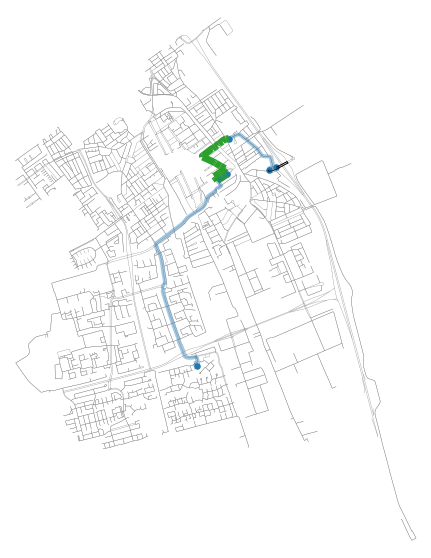

In [22]:
for i in range(params.nV):
    paxes = df[df.veh==i].paxes
    if paxes.apply(lambda x: len(x)).max()>1:
        break
plot_veh(inData.G, df[df.veh ==2], lw = 1)

-----